In [1]:
# Data Set: FD001
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD002
# Train trajectories: 260
# Test trajectories: 259
# Conditions: SIX 
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD003
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

# Data Set: FD004
# Train trajectories: 248
# Test trajectories: 249
# Conditions: SIX 
# Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [133]:
# Reference: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import os
import shutil
import datetime
import seaborn as sns
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from category_encoders import *
from scipy.stats import pearsonr
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.metrics import (mean_squared_log_error, mean_squared_error, make_scorer, confusion_matrix, 
                             roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc,
                             roc_curve)
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, RidgeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

from lightgbm import LGBMRegressor, LGBMClassifier 
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Restructure dataset(s)

In [3]:
train = pd.read_csv('../data/train_FD001.txt', sep=" ", header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


- last 2 cols are 'nan': drop these

In [4]:
train.drop(train.columns[-2:], axis = 1, inplace = True)

##### Rename columns:

In [5]:
cols = ['unit_num', 'cycle']
opSetCols = ['opSetting' + str(i) for i in range(1,4)]
sensorCols = ['sensor' + str(i) for i in range(1,29-7)]
cols += opSetCols + sensorCols
len(train.columns), len(cols)

(26, 26)

In [6]:
train.columns = cols
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [7]:
train.shape, len(train.unit_num.unique()), len(train.cycle.unique())

((20631, 26), 100, 362)

##### Create target variable: 
- Choose maximum cycle for all units as failure
- Reverse order of cycles and set target variable equal to 'CyclesToFailure'

In [8]:
max_cycle = train.groupby('unit_num')['cycle'].max().reset_index()
max_cycle.rename(columns={'cycle': 'max_cycle'}, inplace = True)
max_cycle.head(2)

,unit_num,max_cycle
0,1,192
1,2,287


In [9]:
train = train.merge(max_cycle, left_on='unit_num', right_on='unit_num', how='outer')
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192


In [10]:
train['CyclesToFailure'] = train.max_cycle - train.cycle
train.drop(['cycle', 'max_cycle'], axis = 1, inplace = True)
train.head(2)

,unit_num,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190


#### 2. EDA
- Feature analysis
- Correlations with target variable
- missing-values
- outliers
- etc

##### Check for nan's

In [11]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head()

In [12]:
checkMissingData(train)

,Total,Percent
CyclesToFailure,0,0.0
sensor21,0,0.0
opSetting1,0,0.0
opSetting2,0,0.0
opSetting3,0,0.0


- no missing data

##### Determine if some features are categorical or not:
- determine also whether some features are also redundant

In [13]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 1, 1, 310, 3012, 4051, 1, 2, 513, 53, 6403, 1, 159, 427, 56, 6078, 1918, 1, 13, 1, 1, 120, 4745, 

- Clearly some features are useless as they do not provide more than one type of value
    - remove columns 3, 4, 8, 13, 19, 21, 22

In [14]:
colIndicesToDrop = [3, 4, 8, 13, 19, 21, 22]
colsToDrop = []
for i, col_index in enumerate(colIndicesToDrop):
    colsToDrop.append(train.columns[col_index])
train.drop(colsToDrop, axis = 1, inplace = True)
train.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [15]:
print(train.columns)

Index(['unit_num', 'opSetting1', 'opSetting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'CyclesToFailure'],
      dtype='object')


In [16]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 310, 3012, 4051, 2, 513, 53, 6403, 159, 427, 56, 6078, 1918, 13, 120, 4745, 

##### Check correlations with target variable 
- check for individual unit_numbers

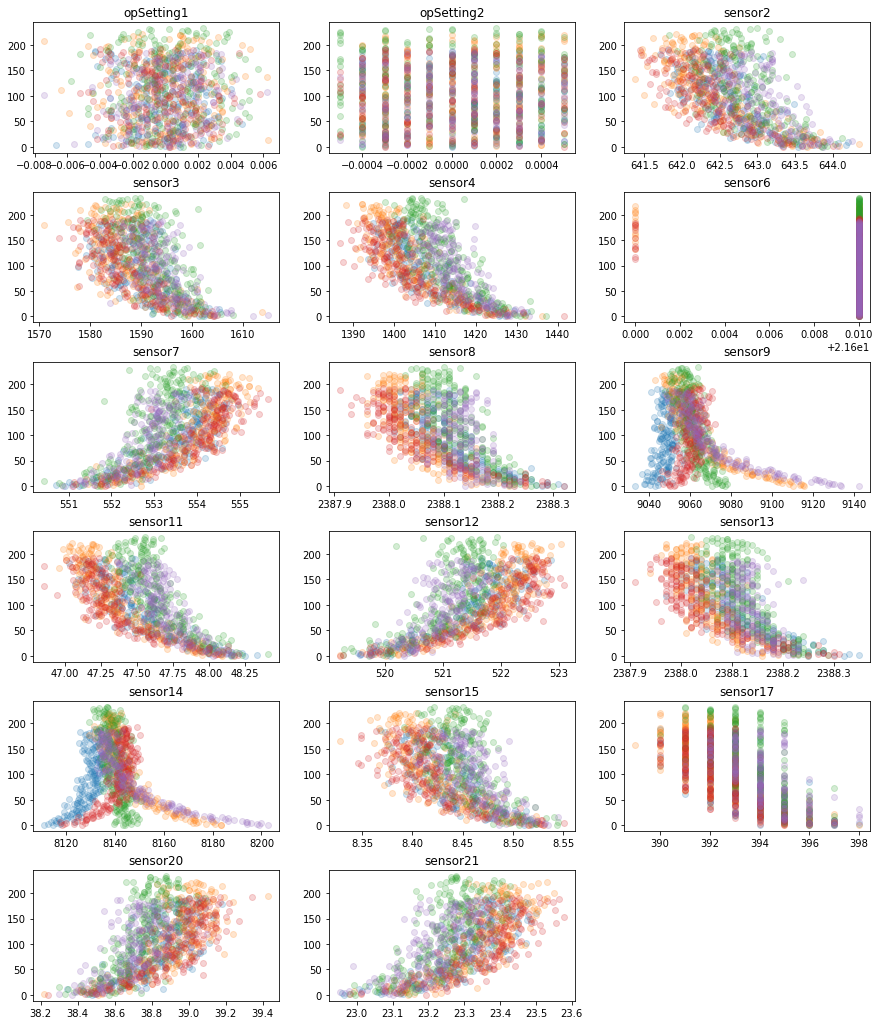

In [17]:
unit_num_list = [1, 10, 20, 30, 40]              # Selected unit-numbers

colList = train.columns[1:-1]
n_cols = 3                                       # 3 plots per row
rows = int(np.ceil(len(colList) / n_cols))    
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    
    axi = f.add_subplot(rows, n_cols, i+1)
    for i, unit_num in enumerate(unit_num_list):
        df = train[train.unit_num == unit_num]
        plt.scatter(df[col], df.CyclesToFailure, alpha = 0.2)# label = col + '_unit' + str(unit_num), alpha = 0.2)

    plt.title(col)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

- clearly sensor17 and opSetting2 are categorical variables:
        - set their values to categorical numerical values

In [18]:
le = LabelEncoder()
cat_vars = ['sensor17', 'opSetting2']
for var in cat_vars:
      train[var] = le.fit_transform(train[var])

In [19]:
train.head(2)

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,2,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,4,39.06,23.4190,191
1,1,0.0019,3,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,4,39.00,23.4236,190


In [20]:
train.dtypes

unit_num             int64
opSetting1         float64
opSetting2           int64
sensor2            float64
sensor3            float64
sensor4            float64
sensor6            float64
sensor7            float64
sensor8            float64
sensor9            float64
sensor11           float64
sensor12           float64
sensor13           float64
sensor14           float64
sensor15           float64
sensor17             int64
sensor20           float64
sensor21           float64
CyclesToFailure      int64
dtype: object

##### Heat Map

- Take unit-1 as an example

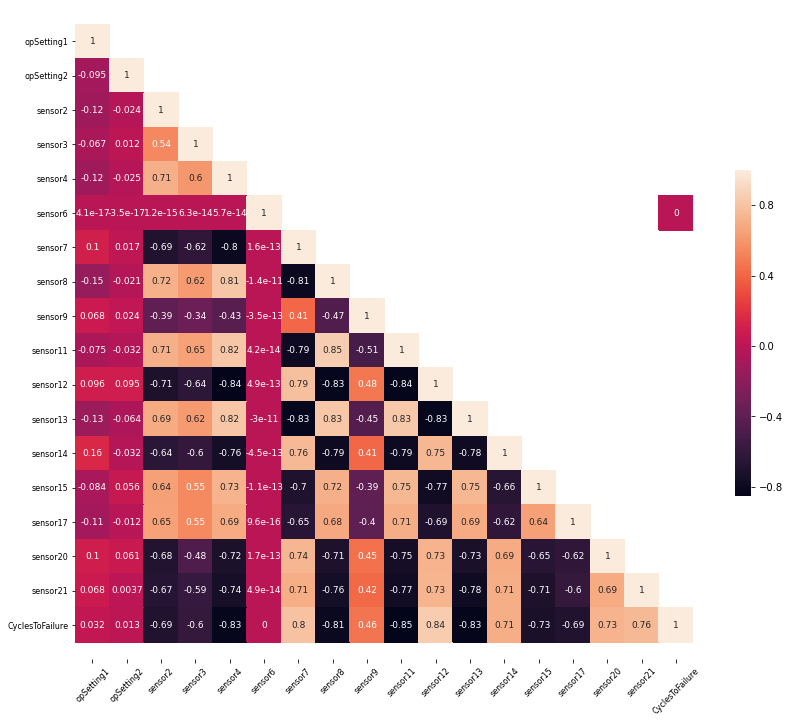

In [21]:
df = train[train.unit_num == 1]
df.drop(['unit_num'], axis = 1, inplace = True)
cor_mat= df[2:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(15,12)
ax = sns.heatmap(data=cor_mat,mask=mask,square=True,cbar_kws={"shrink": .5}, annot=True,cbar=True, annot_kws={"fontsize":9})
ylim_lower = (ax.get_ylim()[0] + 0.5)
ylim_upper = (ax.get_ylim()[1] - 0.5)
ax.set_ylim(ylim_lower, ylim_upper)
plt.xticks(rotation=45, fontsize = 8) 
_ = plt.yticks(rotation=0, fontsize = 8) 

- Sensor 6 clearly shows very little correlation with failure as seen in the scatter plot above
    - confirm with pearsons correlation for all unit-numbers:

In [22]:
train.sensor6.value_counts()

21.61    20225
21.60      406
Name: sensor6, dtype: int64

In [23]:
train.drop(['sensor6'], axis = 1, inplace = True)

- Further visualisation:
    - Scale each feature (holding unit_number constant) and then convert all to PCA 

In [24]:
def scaleData(df):
    mm = MinMaxScaler() #StandardScaler()
    df_ = df.copy()
    df_[df_.columns[1:-1]] = mm.fit_transform(df[df.columns[1:-1]])
    return df_

def convertToPCA(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['FailureGrade'] = df.FailureGrade.values
    return df_PCA

In [25]:
list_dfs = []
for unit_number in train.unit_num.unique():
    df = train[train.unit_num == unit_number]
    df_ = scaleData(df)
    list_dfs.append(df_)
    
train_ = pd.concat(list_dfs)

In [26]:
train_.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,0.526316,0.000000,0.044,0.434626,0.180277,0.859155,0.18750,0.463380,0.338462,0.639640,0.131579,0.933895,0.332039,0.250,0.857143,0.850490,191
1,1,0.754386,0.111111,0.176,0.510776,0.245506,0.715962,0.12500,0.387638,0.353846,0.825826,0.263158,0.693423,0.411650,0.250,0.785714,0.858991,190
2,1,0.210526,0.777778,0.256,0.373204,0.272727,0.835681,0.25000,0.704537,0.184615,0.867868,0.157895,0.752108,0.321036,0.000,0.726190,0.712253,189
3,1,0.649123,0.444444,0.256,0.186422,0.212892,0.880282,0.34375,0.580922,0.076923,1.000000,0.289474,0.772344,0.000000,0.250,0.642857,0.767141,188
4,1,0.421053,0.222222,0.264,0.188578,0.324602,0.774648,0.18750,0.783494,0.192308,0.798799,0.184211,0.771332,0.396117,0.375,0.666667,0.823508,187


##### Set classes as follows:
- x < 70%         CyclesToFailure 
    - normal working condition
- 70% <= x < 90% CyclesToFailure           
    - degraded working condition
- 90% <= x       CyclesToFailure           
    - failing working condition

In [27]:
list_dfs = []
for unit_number in train_.unit_num.unique():
    df = train_[train_.unit_num == unit_number]
    df['FailureGrade'] = 0
    max_cycle = max(df.CyclesToFailure)
    mod_threshold = int(0.3*max_cycle)
    fail_threshold = int(0.1*max_cycle)
    df.loc[df.CyclesToFailure <= mod_threshold, 'FailureGrade'] = 1
    df.loc[df.CyclesToFailure <= fail_threshold, 'FailureGrade'] = 2
    list_dfs.append(df)
train_ = pd.concat(list_dfs)
train_.tail()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
20626,100,0.444444,0.3,0.800000,0.590143,0.868281,0.187032,0.655172,0.635007,0.748031,0.063333,0.935484,0.187578,0.654309,0.875,0.336538,0.062636,4,2
20627,100,0.333333,0.1,0.821739,0.797456,1.000000,0.044888,0.793103,0.621099,0.724409,0.126667,0.806452,0.119255,0.745992,0.625,0.153846,0.352290,3,2
20628,100,0.518519,0.6,0.769565,0.732591,0.856307,0.064838,0.827586,0.647897,0.763780,0.236667,0.870968,0.401863,1.000000,1.000,0.288462,0.000000,2,2
20629,100,0.379630,0.9,0.686957,0.821622,0.812400,0.000000,0.862069,0.913161,1.000000,0.123333,0.838710,0.292547,0.871242,0.625,0.144231,0.203646,1,2
20630,100,0.185185,0.1,0.956522,0.666455,0.961682,0.027431,0.896552,0.497965,0.850394,0.000000,0.935484,0.170807,0.694389,0.750,0.221154,0.185260,0,2


##### Remove unit_num and convert all scaled values to 2 PCA components
- visualise their distributions according to the 3 predefined classes above 

In [28]:
train_.drop('unit_num', axis = 1, inplace = True)

<Figure size 1080x216 with 0 Axes>

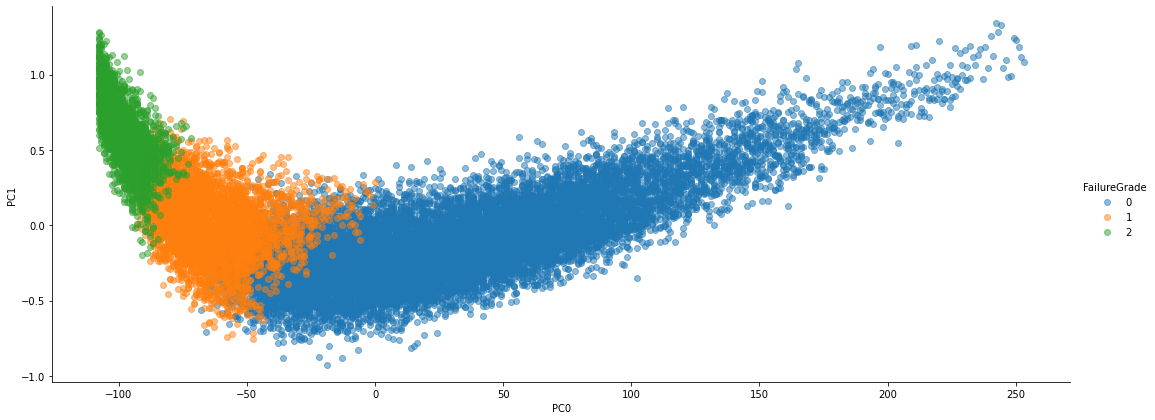

In [29]:
# Visualise failure grades through colours:
df = convertToPCA(train_, nComponents = 2)
f = plt.figure(figsize=(15,3))
explore = sns.PairGrid(data=df, x_vars = 'PC0', y_vars = 'PC1', hue="FailureGrade", size=6, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

##### 3 Component PCA

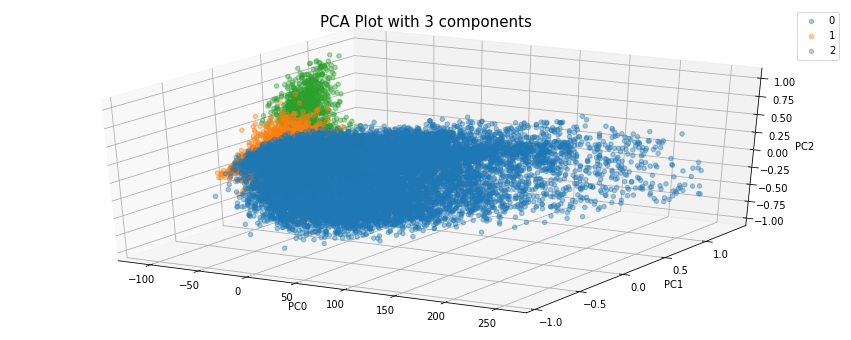

In [30]:
f = plt.figure(figsize=(15,6))
df = convertToPCA(train_, nComponents = 3)
ax = f.add_subplot(111, projection='3d')
for failure_grade in df.FailureGrade.unique():
    df_ = df[df.FailureGrade == failure_grade]
    ax.scatter(df_.PC0, df_.PC1, df_.PC2, marker='o', label = str(failure_grade), alpha = 0.4)

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.legend()
plt.title('PCA Plot with 3 components', fontsize = 15)
plt.show()

- Classes are clearly quite separable (slight overlap with failure-grades '0' and '1' as seen 2-component plot above:

#### 3. Regression & Classification dataset preparation

##### reshuffle datasets: 
    - (the dataset is still inherently ordered by unit number and cycles to failure)

In [31]:
train = train.sample(frac=1)
train_ = train_.sample(frac=1)
train_.head()

,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
11220,0.682171,0.100000,0.536697,0.626506,0.284929,0.438538,0.650000,0.626100,0.747475,0.362205,0.368421,0.579683,0.911681,0.428571,0.259740,0.389161,34,1
21,0.605263,0.444444,0.424000,0.550647,0.179507,0.687793,0.125000,1.000000,0.161538,0.741742,0.157895,0.656998,0.227832,0.250000,0.690476,0.776936,170,0
10961,0.706897,0.600000,0.813043,0.435598,0.361401,0.423858,0.388889,0.610701,0.578947,0.427984,0.363636,0.601958,0.504598,0.625000,0.333333,0.190932,18,2
3829,0.520000,0.200000,0.398190,0.670870,0.401109,0.587879,0.531250,0.017216,0.390805,0.818815,0.392857,0.565789,0.362278,0.285714,0.685393,0.703287,104,0
6539,0.639175,0.900000,0.267658,0.453130,0.153965,0.649891,0.325000,0.721460,0.359712,0.718905,0.315789,0.533333,0.400202,0.333333,0.483146,0.585597,72,0


##### Drop columns which risk target leakage
    - drop unit_num to avoid target leakage:
    - drop opSetting variables as they may uniquely identify a unit and therefore identify give clues about failure (num_cycles etc)?

- classification dataframe

In [32]:
train_classif = train_.drop(['opSetting1', 'opSetting2', 'CyclesToFailure'], axis = 1)
train_classif.head(2)

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,FailureGrade
11220,0.536697,0.626506,0.284929,0.438538,0.650,0.6261,0.747475,0.362205,0.368421,0.579683,0.911681,0.428571,0.259740,0.389161,1
21,0.424000,0.550647,0.179507,0.687793,0.125,1.0000,0.161538,0.741742,0.157895,0.656998,0.227832,0.250000,0.690476,0.776936,0


- regression dataframes

In [33]:
train_.drop(['FailureGrade', 'opSetting1', 'opSetting2'], axis = 1, inplace = True)
train_.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
11220,0.536697,0.626506,0.284929,0.438538,0.650000,0.626100,0.747475,0.362205,0.368421,0.579683,0.911681,0.428571,0.259740,0.389161,34
21,0.424000,0.550647,0.179507,0.687793,0.125000,1.000000,0.161538,0.741742,0.157895,0.656998,0.227832,0.250000,0.690476,0.776936,170
10961,0.813043,0.435598,0.361401,0.423858,0.388889,0.610701,0.578947,0.427984,0.363636,0.601958,0.504598,0.625000,0.333333,0.190932,18
3829,0.398190,0.670870,0.401109,0.587879,0.531250,0.017216,0.390805,0.818815,0.392857,0.565789,0.362278,0.285714,0.685393,0.703287,104
6539,0.267658,0.453130,0.153965,0.649891,0.325000,0.721460,0.359712,0.718905,0.315789,0.533333,0.400202,0.333333,0.483146,0.585597,72


In [34]:
train.drop(['unit_num', 'opSetting1', 'opSetting2'], axis = 1, inplace = True)
train.head(2)

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
3414,642.38,1585.52,1402.47,554.42,2388.03,9062.73,47.38,522.00,2388.01,8145.26,8.4198,3,38.98,23.3504,166
17957,643.09,1593.24,1407.15,553.42,2388.11,9086.18,47.54,521.31,2388.07,8164.88,8.4667,6,38.82,23.1784,51


In [35]:
train.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
3414,642.38,1585.52,1402.47,554.42,2388.03,9062.73,47.38,522.00,2388.01,8145.26,8.4198,3,38.98,23.3504,166
17957,643.09,1593.24,1407.15,553.42,2388.11,9086.18,47.54,521.31,2388.07,8164.88,8.4667,6,38.82,23.1784,51
14868,642.59,1588.29,1395.87,553.67,2388.07,9063.33,47.50,521.35,2388.06,8143.23,8.4324,5,38.90,23.2421,61
7668,642.67,1589.31,1410.67,553.54,2388.14,9062.06,47.62,521.76,2388.12,8136.97,8.4464,7,38.69,23.3200,157
18219,643.33,1599.81,1429.88,551.31,2388.25,9076.24,48.04,520.36,2388.19,8144.51,8.5125,8,38.48,23.0963,6


# ----------------------------------------------------------------------------------------------------------------
#### 4. Regression model
##### Define relevant functions

In [76]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def run_train_test_split(df, estimator):
    n_splits = 4
    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
   
    #### Sometimes exception is thrown: (Need to address this issue)
    try:
        cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=n_splits, n_jobs = -1)
        return cval.mean()
    except: 
        
        kf = KFold(n_splits, True, 1)
        rmsleScores = []

        for train_index, test_index in kf.split(X):
            trainX, testX = X[train_index], X[test_index]
            trainy, testy = y[train_index], y[test_index]
            model_ = clone(estimator)
            model_.fit(trainX,trainy)
            preds = model_.predict(testX)
            rmsleScore = rmsle(np.exp(testy), np.exp(preds))
            rmsleScores.append(rmsleScore)

        return round(sum(rmsleScores) / n_splits, 3)


## -----------------------------------------------------------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True, printFeatureImp = False, returnDataPoints = False):

    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    datapoints = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        if returnDataPoints:
            datapoints.append([[testy], [preds]])
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
        if printFeatureImp:
            print("Features sorted by their score:")
            print(sorted(zip(map(lambda x: round(x, 4), model_.feature_importances_), df.columns[:-1]), 
                 reverse=True))        
    if returnVal & returnDataPoints:
        return round(sum(rmsleScores) / n_splits, 3), datapoints
    
    elif returnVal:
        return round(sum(rmsleScores) / n_splits, 3)
    
#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------

def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    #return np.sqrt(np.mean(np.square(np.log1p(ytrue) - np.log1p(ypred))))
    except:
        ypred = pd.DataFrame(ypred)
        print(ypred)#ypred[ypred<0]
    #return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   
    
    
#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   XGBoost optimiser   -------
def optimiseXGBoost(data, pbounds_):
    
    def train_bayes_opt_XGBoost(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = xgb.XGBRegressor(**params_, silent = True)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_XGBoost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   Lasso optimiser   -------
def optimiseLasso(data, pbounds_):
    
    def train_bayes_opt_Lasso(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Lasso(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Lasso, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params


## -----------------------------------------------------------------------------------------------------------------------

# -------   Ridge optimiser   -------
def optimiseRidge(data, pbounds_):
    
    def train_bayes_opt_Ridge(alpha): #kernel, 
        params_ = {       
        #'kernel': kernel,
        'alpha': alpha
        }
        mdl = Ridge(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_Ridge, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max

    return max_params

##### Quick test of random forest model with default features:
- Explore feature importance

In [32]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(df = train, n_splits = 4, model = rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  42.09, 41.76, 41.68, 41.27, Average RMSLE:  41.699
Features sorted by their score:
[(0.397, 'sensor11'), (0.1339, 'sensor4'), (0.1212, 'sensor9'), (0.053, 'sensor12'), (0.0429, 'sensor14'), (0.0382, 'sensor7'), (0.0364, 'sensor15'), (0.0343, 'sensor21'), (0.0316, 'sensor3'), (0.03, 'sensor2'), (0.027, 'sensor20'), (0.0223, 'sensor13'), (0.0209, 'sensor8'), (0.0111, 'sensor17')]


In [33]:
rfModel = RandomForestRegressor(n_estimators=100)
#run_train_test_split(train, rfModel)testModel
testModel(train, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  42.11, 41.7, 41.76, 41.3, Average RMSLE:  41.717
Features sorted by their score:
[(0.4012, 'sensor11'), (0.1271, 'sensor4'), (0.1229, 'sensor9'), (0.0545, 'sensor12'), (0.0421, 'sensor14'), (0.0381, 'sensor7'), (0.0368, 'sensor15'), (0.0346, 'sensor21'), (0.0315, 'sensor3'), (0.0305, 'sensor2'), (0.0267, 'sensor20'), (0.0219, 'sensor13'), (0.0214, 'sensor8'), (0.0108, 'sensor17')]


In [104]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(train_, 4, rfModel, returnVal = False, printOutput = True, printFeatureImp = True)

RMSLE Value For Kf_i:  36.63, 36.48, 36.1, 35.68, Average RMSLE:  36.223
Features sorted by their score:
[(0.464, 'sensor11'), (0.1093, 'sensor4'), (0.0846, 'sensor12'), (0.0656, 'sensor9'), (0.0483, 'sensor7'), (0.0335, 'sensor15'), (0.0315, 'sensor14'), (0.0298, 'sensor20'), (0.0283, 'sensor13'), (0.0282, 'sensor21'), (0.0244, 'sensor2'), (0.0226, 'sensor8'), (0.022, 'sensor3'), (0.0079, 'sensor17')]


- considerable improvement with scaled features

##### Optimise several models with Bayesian optimisation
- choose from lightGBM, RandomForest, GradientBoost & XGBoost as decision-tree based algorithms
- choose from linear regression (with without penalties) i.e. Lasso, Ridge 

##### Random Forest

In [37]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(train_, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = train_, n_splits = 10, model = rfModel, printFeatureImp = True)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.3482   |  44.62    |  0.007203 |  50.02    |
|  2        | -0.3446   |  33.72    |  0.001468 |  68.47    |
|  3        | -0.3456   |  22.69    |  0.003456 |  129.4    |
|  4        | -0.3448   |  56.19    |  0.004192 |  187.0    |
|  5        | -0.3491   |  24.42    |  0.008781 |  55.48    |
|  6        | -0.3451   |  68.69    |  0.004173 |  161.7    |
|  7        | -0.3439   |  18.34    |  0.001981 |  210.1    |
|  8        | -0.3446   |  96.98    |  0.003134 |  188.5    |
|  9        | -0.3484   |  88.26    |  0.008946 |  67.01    |
|  10       | -0.3552   |  8.71     |  0.001698 |  225.6    |
|  11       | -0.3457   |  99.55    |  0.005485 |  249.7    |
|  12       | -0.423    |  5.115    |  0.005598 |  175.8    |
|  13       | -0.3448   |  46.19    |  0.004018 |  250.0    |
|  14       | -0.3475   |  99.89    |  0.009434 |  119.8    |
|  15   

##### LightGBM

In [38]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM(train_, bounds_)
lgbmMod = LGBMRegressor(**max_params['params'])
newVal = testModel(df = train_, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1601   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.1602   |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.1816   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.1608   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.1634   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.1982   |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.163    |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.1716   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.1788   |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.1609   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.1632   |  0.0      |  0.1      |  10.0     |  1e+03    |
|  12       | -0.1628   |  0.0      | 

##### Scikit-learn Gradient Boosting

In [39]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost(train_, bounds_)
gbModel = GradientBoostingRegressor(**max_params['params'])
newVal = testModel(df = train_, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1729   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.1575   |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.1735   |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.1647   |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.1726   |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.1926   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.1968   |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.1625   |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.2042   |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.1861   |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.1587   |  0.1      |  1.0      |  0.01     |  1e+03    |
|  12       | -0.1608   |  0.8      | 

In [68]:
testModel(df = train_, n_splits = 10, model = gbModel)

RMSLE Value For Kf_i:  34.61, 34.6, 34.49, 34.73, 34.64, 33.37, 35.07, 34.73, 33.77, 35.65, Average RMSLE:  34.568


##### XGBoost

- XGBoost (with determined hyperparameters) predicts infinite values leading to a ValueError exception:
    - #TODO

##### Remove ordinal nature of categorical columns for linear models

- 'sensor17' is a categorical variable: 
    - Need to remove ordinal nature of data which could adversely affect linear-based techniques
        - convert to one-hot encoding
        - reduce number of dimensions through PCA (reduce risk of curse of dimensionality)

In [38]:
train_.sensor17 = train.sensor17

cat_vars = ['sensor17']
train_one = train_.copy()
for i, var in enumerate(cat_vars):
    temp = pd.get_dummies(train_one[var],prefix=var, drop_first = True )
    train_one = pd.concat([train_one,temp], axis=1)
    train_one.drop(var, axis=1, inplace = True)

print(train_one.shape)
cols = list(train_one)
cols.insert(len(cols)-1, cols.pop(cols.index('CyclesToFailure')))
train_one = train_one[cols]
train_one.head(2)

(20631, 26)


,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor20,sensor21,sensor17_1,sensor17_2,sensor17_3,sensor17_4,sensor17_5,sensor17_6,sensor17_7,sensor17_8,sensor17_9,sensor17_10,sensor17_11,sensor17_12,CyclesToFailure
11220,0.536697,0.626506,0.284929,0.438538,0.650,0.6261,0.747475,0.362205,0.368421,0.579683,0.911681,0.259740,0.389161,0,0,0,0,0,1,0,0,0,0,0,0,34
21,0.424000,0.550647,0.179507,0.687793,0.125,1.0000,0.161538,0.741742,0.157895,0.656998,0.227832,0.690476,0.776936,0,0,0,1,0,0,0,0,0,0,0,0,170


##### Determine best number of components for PCA

In [39]:
def convertToPCA_reg(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['CyclesToFailure'] = df.CyclesToFailure.values
    return df_PCA

In [43]:
max_params = {}
max_params['params'] = {}
max_params['params']['max_depth'] = 2
max_params['params']['min_impurity_decrease'] =  0.001862602113776709
max_params['params']['learning_rate'] = 0.20272912357197914
max_params['params']['n_estimators'] = 378

gbModel = GradientBoostingRegressor(**max_params['params'])

number of Components:  = 1
RMSLE Value For Kf_i:  42.07, 41.73, 41.81, 42.67, 41.93, 40.73, 43.42, 42.07, 40.95, 42.99, Average RMSLE:  42.037
Features sorted by their score:
[(1.0, 'PC0')]
number of Components:  = 2
RMSLE Value For Kf_i:  37.89, 37.17, 37.48, 37.88, 38.08, 36.45, 38.49, 38.07, 36.7, 38.32, Average RMSLE:  37.653
Features sorted by their score:
[(0.8973, 'PC0'), (0.1027, 'PC1')]
number of Components:  = 3
RMSLE Value For Kf_i:  37.72, 37.0, 37.4, 37.69, 37.91, 36.25, 38.21, 38.13, 36.51, 38.1, Average RMSLE:  37.494
Features sorted by their score:
[(0.8485, 'PC0'), (0.1122, 'PC2'), (0.0393, 'PC1')]
number of Components:  = 4
RMSLE Value For Kf_i:  37.51, 36.81, 37.39, 37.71, 37.73, 36.18, 38.28, 37.79, 36.31, 38.4, Average RMSLE:  37.41
Features sorted by their score:
[(0.8414, 'PC0'), (0.0861, 'PC2'), (0.039, 'PC3'), (0.0335, 'PC1')]
number of Components:  = 5
RMSLE Value For Kf_i:  37.33, 36.44, 37.24, 37.42, 37.18, 35.48, 37.76, 37.53, 35.79, 37.71, Average RMSLE:  

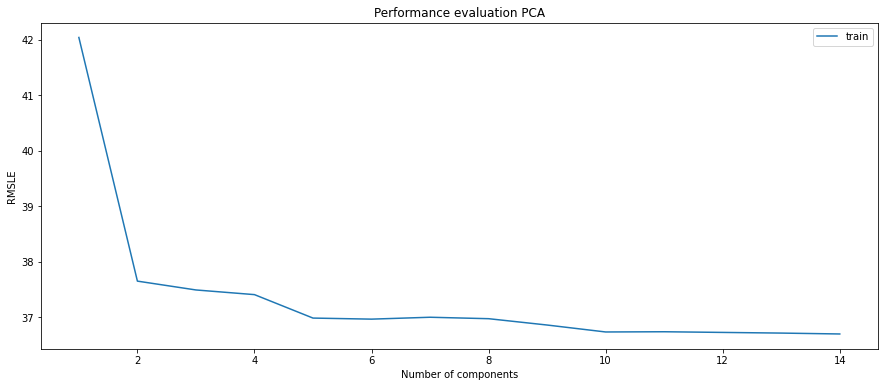

In [73]:
result = []
scaled_result = []
for nComponents in range(1, 15):
    print("{} = {}".format('number of Components: ', nComponents))
    df_PCA_one = convertToPCA_reg(train_one, nComponents)
    
    # Presaved Gradient Boosting max_params (best performing model):
    newVal = testModel(df = df_PCA_one, n_splits = 10, model = gbModel, returnVal = True, printFeatureImp = True)
    result.append(newVal)
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(1, len(result)+1), result, label = 'train')
plt.legend()

_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

- PCA with 10 components (negligible change beyond)

In [107]:
df_PCA_one = convertToPCA_reg(train_one, 10)

##### Linear regression with/ without penalties and 14 principal components

In [108]:
df_PCA_one.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,CyclesToFailure
0,-0.618187,0.766093,0.035762,-0.098458,0.335892,0.044402,0.072153,-0.005726,-0.194447,-0.087809,160
1,-0.326495,0.774908,-0.037811,-0.154966,0.363995,0.120527,-0.022679,-0.012823,-0.016460,0.084042,112
2,-0.485190,0.767049,-0.005999,-0.116088,0.184767,0.012607,0.036297,-0.017875,-0.282821,-0.070424,99
3,0.154568,-0.086428,-0.168524,0.503838,0.444451,-0.637456,0.231366,-0.028402,0.066304,-0.047038,68
4,-0.324164,0.775881,-0.039851,-0.155586,0.343835,0.110754,-0.030923,-0.011192,0.052754,0.316840,125


In [109]:
df_PCA_one_ = df_PCA_one.copy()

##### Linear regression

In [110]:
lModel = LinearRegression()
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lModel)

RMSLE Value For Kf_i:  41.0, 40.01, 39.52, 40.96, 39.11, 40.38, 40.2, 38.32, 39.84, 38.42, Average RMSLE:  39.777


##### Lasso regression

In [117]:
bounds_ = {
        'alpha': (0.001,1),
        }

max_params = optimiseLasso(df_PCA_one, bounds_)
lassoModel = Lasso(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = lassoModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  40.24    |  0.4176   |
|  2        |  40.67    |  0.7206   |
|  3        |  39.79    |  0.001114 |
|  4        |  40.1     |  0.303    |
|  5        |  39.9     |  0.1476   |
|  6        |  39.85    |  0.09325  |
|  7        |  39.94    |  0.1871   |
|  8        |  40.16    |  0.3462   |
|  9        |  40.22    |  0.3974   |
|  10       |  40.4     |  0.5393   |
|  11       |  41.01    |  1.0      |
|  12       |  41.01    |  1.0      |
|  13       |  41.01    |  1.0      |
|  14       |  41.01    |  1.0      |
|  15       |  41.01    |  1.0      |
|  16       |  41.01    |  1.0      |
|  17       |  41.01    |  1.0      |
|  18       |  41.01    |  1.0      |
|  19       |  41.01    |  1.0      |
|  20       |  41.01    |  1.0      |
|  21       |  41.01    |  1.0      |
|  22       |  41.01    |  1.0      |
|  23       |  41.01    |  1.0      |
|  24       |  41.01    |  1.0      |
|  25       

##### Ridge regression

In [118]:
bounds_ = {
        'alpha': (0.0000001,1),
        }

max_params = optimiseRidge(df_PCA_one, bounds_)
ridgeModel = Ridge(**max_params['params'])
newVal = testModel(df = df_PCA_one, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  39.79    |  0.417    |
|  2        |  39.79    |  0.7203   |
|  3        |  39.79    |  0.000114 |
|  4        |  39.79    |  0.3023   |
|  5        |  39.79    |  0.1468   |
|  6        |  39.79    |  0.09234  |
|  7        |  39.79    |  0.1863   |
|  8        |  39.79    |  0.3456   |
|  9        |  39.79    |  0.3968   |
|  10       |  39.79    |  0.5388   |
|  11       |  39.79    |  0.1418   |
|  12       |  39.79    |  0.7309   |
|  13       |  39.79    |  0.3906   |
|  14       |  39.79    |  0.7741   |
|  15       |  39.79    |  0.3443   |
|  16       |  39.79    |  0.1676   |
|  17       |  39.79    |  0.7919   |
|  18       |  39.79    |  0.6207   |
|  19       |  39.79    |  0.5876   |
|  20       |  39.79    |  0.3377   |
|  21       |  39.79    |  0.7688   |
|  22       |  39.79    |  0.9614   |
|  23       |  39.79    |  0.03482  |
|  24       |  39.79    |  0.1993   |
|  25       

##### Gradient Boosting was best performing:
- lets see how the predictions faired:

In [120]:
newVal, datapoints = testModel(df = train_, n_splits = 10, model = gbModel, returnVal = True, returnDataPoints = True)

RMSLE Value For Kf_i:  35.37, 34.75, 34.4, 35.29, 34.22, 34.55, 35.23, 33.27, 33.75, 33.28, Average RMSLE:  34.412


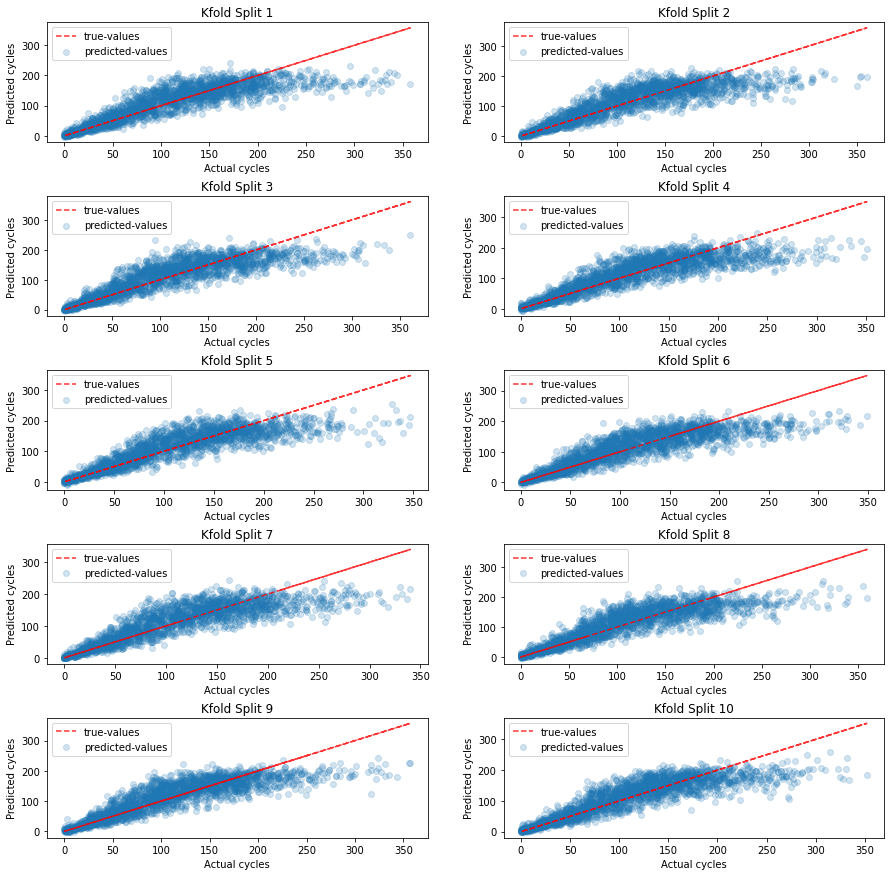

In [121]:
n_cols = 2                                       # 2 plots per row
rows = int(np.ceil(len(datapoints) / n_cols))
f = plt.figure(figsize=(15,3*rows))

for i in range(len(datapoints)):
    truePoints = datapoints[i][0]
    predPoints = datapoints[i][1]
    axi = f.add_subplot(rows, n_cols, i+1)
    plt.plot(datapoints[i][0][0], datapoints[i][0][0], 'r--', alpha = 0.8, label ='true-values')
    plt.scatter(datapoints[i][0], datapoints[i][1], alpha = 0.2, label ='predicted-values')
    axi.set_xlabel('Actual cycles')
    axi.set_ylabel('Predicted cycles')
    plt.title('Kfold Split ' + str(i+1), fontsize = 12)
    plt.legend()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.45)

# ------------------------------------------------------------------------------------------------------------
#### 4. Classification model - Multi-class (3 Labels)
##### Define relevant functions

In [44]:
# Average classwise accuracy given class sizes are imbalanced
def evaluate(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    cm_ = confusion_matrix(y_true, y_pred)
    cm = cm_.astype('float') / cm_.sum(axis=1)[:, np.newaxis]
    return np.nanmean(np.diagonal(cm)), cm_

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ 
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set(style="ticks", font_scale=1)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size= 12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size = 8)
    plt.yticks(tick_marks, classes, size = 8)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", size= 20)

    plt.tight_layout()
    plt.ylabel('True label', size= 10)
    plt.xlabel('Predicted label', size= 10)


- Try and predict one of 3 classes or **FailureGrades** 
- Try predict 3 classes and compare results with reducing to a 2-class problem

In [49]:
print(train_classif.shape)
train_classif.head()

(20631, 15)


,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,FailureGrade
11220,0.536697,0.626506,0.284929,0.438538,0.650000,0.626100,0.747475,0.362205,0.368421,0.579683,0.911681,0.428571,0.259740,0.389161,1
21,0.424000,0.550647,0.179507,0.687793,0.125000,1.000000,0.161538,0.741742,0.157895,0.656998,0.227832,0.250000,0.690476,0.776936,0
10961,0.813043,0.435598,0.361401,0.423858,0.388889,0.610701,0.578947,0.427984,0.363636,0.601958,0.504598,0.625000,0.333333,0.190932,2
3829,0.398190,0.670870,0.401109,0.587879,0.531250,0.017216,0.390805,0.818815,0.392857,0.565789,0.362278,0.285714,0.685393,0.703287,0
6539,0.267658,0.453130,0.153965,0.649891,0.325000,0.721460,0.359712,0.718905,0.315789,0.533333,0.400202,0.333333,0.483146,0.585597,0


In [184]:
train_classif.FailureGrade.unique()

array([0, 1, 2], dtype=int64)

- try classification test using Random Forest Classifier with default parameters

Avg Class-wise accuracy = 0.89


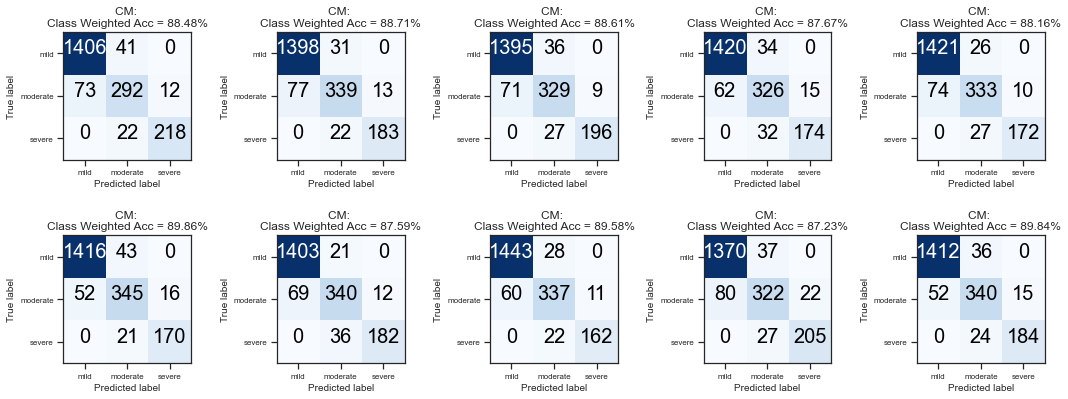

In [48]:
rf = RandomForestClassifier()

n_splits = 10
kf = KFold(n_splits, True, 1)
X = train_classif.drop(['FailureGrade'], axis = 1).values
y = train_classif.drop(train_classif.columns.difference(['FailureGrade']), axis = 1).values

split_scores = []
cm_list = []
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    model_ = clone(rf)
    model_.fit(trainX,trainy)
    preds = model_.predict(testX)
    classWiseAcc, cm = evaluate(testy, preds)
    split_scores.append(classWiseAcc)
    cm_list.append(cm)
    #print('classWiseAcc = {}'.format(classWiseAcc))
    
            
print('Avg Class-wise accuracy = {}'.format(round(sum(split_scores)/len(split_scores), 2)))
n_cols = 5                                      # 2 plots per row
rows = int(np.ceil(len(cm_list) / n_cols))
f = plt.figure(figsize=(15,3*rows))
classes = ['mild', 'moderate', 'severe']
for i, cm in enumerate(cm_list):
    axi = f.add_subplot(rows, n_cols, i+1)
    plot_confusion_matrix(cm, classes, normalize=False, title='CM: \nClass Weighted Acc = '+ str(round(split_scores[i]*100, 2)) + '%', cmap=plt.cm.Blues)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.005)

- Hyperparameter tuning: 

In [97]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def evaluate_classifier(df, estimator):
    n_splits = 4
    X = df.drop(['FailureGrade'], axis = 1).values
    y = df.drop(df.columns.difference(['FailureGrade']), axis = 1).values
    weighted_acc_scorer = make_scorer(weighted_acc, greater_is_better=True)
   
    #### Sometimes exception is thrown: (Need to address this issue)
    try:
        cval = cross_val_score(estimator, X, y, scoring=weighted_acc_scorer, cv=n_splits, n_jobs = -1)
        return cval.mean()
    except: 
        
        kf = KFold(n_splits, True, 1)
        acc_scores = []

        for train_index, test_index in kf.split(X):
            trainX, testX = X[train_index], X[test_index]
            trainy, testy = y[train_index], y[test_index]
            model_ = clone(estimator)
            model_.fit(trainX,trainy)
            preds = model_.predict(testX)
            classWiseAcc = weighted_acc(testy, preds)
            split_scores.append(classWiseAcc)

        return round(sum(split_scores) / n_splits, 4)



## -----------------------------------------------------------------------------------------------------------------------

def testModel_clf(df, n_splits, model, returnVal = False, printOutput = True, printFeatureImp = False, returnDataPoints = False):

    X = df.drop(['FailureGrade'], axis = 1).values
    y = df.drop(df.columns.difference(['FailureGrade']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    split_scores = []
    datapoints = []
    
    if printOutput:
        print("Weighted Acc for Kf_i: ", end = ' ')
        
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        classWiseAcc = weighted_acc(testy, preds)
        split_scores.append(classWiseAcc)
        if returnDataPoints:
            datapoints.append([[testy], [preds]])
        if printOutput:
            print(round(classWiseAcc, 2), end = ', ')
    
    if printOutput:
        print ("Average Weighted Acc: ", round(sum(split_scores) / n_splits, 3))
        if printFeatureImp:
            print("Features sorted by their score:")
            print(sorted(zip(map(lambda x: round(x, 4), model_.feature_importances_), df.columns[:-1]), 
                 reverse=True))        
    
    if returnVal & returnDataPoints:
        return round(sum(split_scores) / n_splits, 4), datapoints
    
    elif returnVal:
        return round(sum(split_scores) / n_splits, 4)
    
    
#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------

def weighted_acc(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return np.nanmean(np.diagonal(cm))
    
    
#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF_clf(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestClassifier(**params_)
        return evaluate_classifier(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost_clf(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingClassifier(**params_)
        return evaluate_classifier(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params


## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM_clf(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMClassifier(**params_)
        return evaluate_classifier(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------



# -------   SGD optimiser   -------
def optimiseSGD_clf(data, pbounds_):
    
    def train_bayes_opt_sgd(alpha):
        params_ = {       
        'alpha': alpha,
        'class_weight': 'balanced',
        }
        mdl = SGDClassifier(**params_)
        return evaluate_classifier(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_sgd, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   Ridge optimiser   -------
def optimiseRidge_clf(data, pbounds_):
    
    def train_bayes_opt_ridge(alpha):
        params_ = {       
        'alpha': alpha,
        'class_weight': 'balanced',
        }
        mdl = RidgeClassifier(**params_)
        return evaluate_classifier(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_ridge, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    return max_params

## -----------------------------------------------------------------------------------------------------------------------


##### Random Forest Classifier

In [64]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF_clf(train_classif, bounds_)                                      
rfModel = RandomForestClassifier(**max_params['params'])
testModel_clf(df = train_classif, n_splits = 10, model = rfModel, printFeatureImp = True)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        |  0.839    |  44.62    |  0.007203 |  50.02    |
|  2        |  0.8778   |  33.72    |  0.001468 |  68.47    |
|  3        |  0.8618   |  22.69    |  0.003456 |  129.4    |
|  4        |  0.8571   |  56.19    |  0.004192 |  187.0    |
|  5        |  0.8326   |  24.42    |  0.008781 |  55.48    |
|  6        |  0.8583   |  68.69    |  0.004173 |  161.7    |
|  7        |  0.8738   |  18.34    |  0.001981 |  210.1    |
|  8        |  0.8663   |  96.98    |  0.003134 |  188.5    |
|  9        |  0.838    |  88.26    |  0.008946 |  67.01    |
|  10       |  0.8769   |  8.71     |  0.001698 |  225.6    |
|  11       |  0.9043   |  100.0    |  0.0      |  250.0    |
|  12       |  0.8651   |  49.28    |  0.003303 |  249.9    |
|  13       |  0.8614   |  59.54    |  0.00339  |  99.0     |
|  14       |  0.8378   |  5.052    |  0.008786 |  174.2    |
|  15   

##### Gradient Boosting Classifier

In [71]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseGradBoost_clf(train_classif, bounds_)
gbModel = GradientBoostingClassifier(**max_params['params'])
newVal = testModel_clf(df = train_classif, n_splits = 10, model = gbModel)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9051   |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        |  0.9092   |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        |  0.9056   |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        |  0.9047   |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        |  0.9066   |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        |  0.8868   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        |  0.889    |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        |  0.9046   |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        |  0.8919   |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       |  0.8984   |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       |  0.9105   |  0.1      |  1.0      |  4.62e-08 |  1e+03    |
|  12       |  0.9108   |  0.1      | 

##### LightGBM

In [102]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM_clf(train_classif, bounds_)
lgbmMod = LGBMClassifier(**max_params['params'])
newVal = testModel_clf(df = train_classif, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9116   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        |  0.9121   |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        |  0.9113   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        |  0.9082   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        |  0.9117   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        |  0.8429   |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        |  0.9118   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        |  0.9055   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        |  0.9113   |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       |  0.9076   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       |  0.9116   |  0.0      |  0.1      |  10.0     |  962.3    |
|  12       |  0.912    |  0.0      | 

##### Convert dataframe to PCA to remove numerical column for linear-based classification techniques:

In [73]:
def convertToPCA_clf(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['FailureGrade'] = df.FailureGrade.values
    return df_PCA

In [74]:
# 10 components produced decent results for regression, therefore reuse this number
df_PCA = convertToPCA_clf(df = train_classif, nComponents = 10)

##### SGD Classifier

In [88]:
bounds_ = { 
        'alpha': (0.00001,0.0001),
        }
max_params = optimiseSGD_clf(df_PCA, bounds_)
sgdModel = SGDClassifier(**max_params['params'])
newVal = testModel_clf(df = df_PCA, n_splits = 10, model = sgdModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  0.8745   |  4.753e-0 |
|  2        |  0.8517   |  7.483e-0 |
|  3        |  0.8898   |  1.001e-0 |
|  4        |  0.897    |  3.721e-0 |
|  5        |  0.8672   |  2.321e-0 |
|  6        |  0.8653   |  1.831e-0 |
|  7        |  0.8811   |  2.676e-0 |
|  8        |  0.8998   |  4.11e-05 |
|  9        |  0.877    |  4.571e-0 |
|  10       |  0.8694   |  5.849e-0 |
|  11       |  0.8713   |  0.0001   |
|  12       |  0.8528   |  8.937e-0 |
|  13       |  0.8907   |  6.642e-0 |
|  14       |  0.8916   |  3.949e-0 |
|  15       |  0.8796   |  9.527e-0 |
|  16       |  0.8879   |  3.23e-05 |
|  17       |  0.878    |  8.185e-0 |
|  18       |  0.8437   |  1.305e-0 |
|  19       |  0.8778   |  5.331e-0 |
|  20       |  0.8841   |  6.33e-05 |
|  21       |  0.8887   |  3.51e-05 |
|  22       |  0.8635   |  6.968e-0 |
|  23       |  0.8806   |  4.245e-0 |
|  24       |  0.8813   |  8.521e-0 |
|  25       

##### Ridge Classifier

In [94]:
bounds_ = { 
        'alpha': (0.00001,1),
        }
max_params = optimiseRidge_clf(df_PCA, bounds_)
ridgeModel = RidgeClassifier(alpha = 1)
newVal = testModel_clf(df = df_PCA, n_splits = 10, model = ridgeModel)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  0.6932   |  0.417    |
|  2        |  0.6932   |  0.7203   |
|  3        |  0.6932   |  0.000124 |
|  4        |  0.6932   |  0.3023   |
|  5        |  0.6932   |  0.1468   |
|  6        |  0.6932   |  0.09235  |
|  7        |  0.6932   |  0.1863   |
|  8        |  0.6932   |  0.3456   |
|  9        |  0.6932   |  0.3968   |
|  10       |  0.6932   |  0.5388   |
|  11       |  0.6932   |  0.7135   |
|  12       |  0.6932   |  0.483    |
|  13       |  0.6932   |  0.3908   |
|  14       |  0.6932   |  0.3268   |
|  15       |  0.6932   |  0.866    |
|  16       |  0.6932   |  0.3651   |
|  17       |  0.6932   |  0.3775   |
|  18       |  0.6932   |  0.6498   |
|  19       |  0.6932   |  0.3322   |
|  20       |  0.6932   |  0.8159   |
|  21       |  0.6932   |  0.5128   |
|  22       |  0.6932   |  0.5804   |
|  23       |  0.6932   |  0.09176  |
|  24       |  0.6932   |  0.4531   |
|  25       

##### Use best classifier (lightGBM)
- determine performance in comparison to Random Forest with default parameters

Avg Class-wise accuracy = 0.91


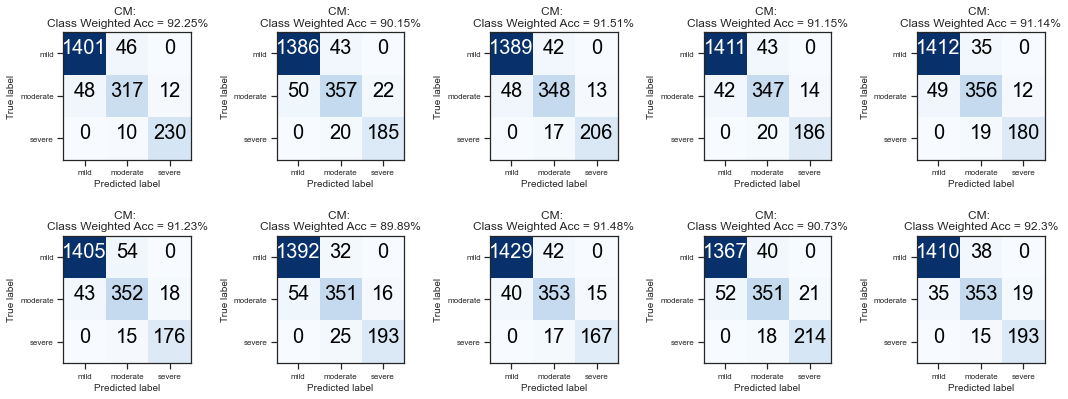

In [101]:
max_params = {}
max_params['params'] = {}
max_params['params']['gamma'] = 0
max_params['params']['learning_rate'] =  0.1
max_params['params']['max_depth'] = 1
max_params['params']['n_estimators'] = 790

lgbmMod = LGBMClassifier(**max_params['params'])

n_splits = 10
kf = KFold(n_splits, True, 1)
X = train_classif.drop(['FailureGrade'], axis = 1).values
y = train_classif.drop(train_classif.columns.difference(['FailureGrade']), axis = 1).values

split_scores = []
cm_list = []
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    model_ = clone(lgbmMod)
    model_.fit(trainX,trainy)
    preds = model_.predict(testX)
    classWiseAcc, cm = evaluate(testy, preds)
    split_scores.append(classWiseAcc)
    cm_list.append(cm)  
            
print('Avg Class-wise accuracy = {}'.format(round(sum(split_scores)/len(split_scores), 2)))
n_cols = 5                                      
rows = int(np.ceil(len(cm_list) / n_cols))
f = plt.figure(figsize=(15,3*rows))
classes = ['mild', 'moderate', 'severe']
for i, cm in enumerate(cm_list):
    axi = f.add_subplot(rows, n_cols, i+1)
    plot_confusion_matrix(cm, classes, normalize=False, title='CM: \nClass Weighted Acc = '+ str(round(split_scores[i]*100, 2)) + '%', cmap=plt.cm.Blues)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.005)

# ------------------------------------------------------------------------------------------------------------
#### 5. Binary-class classifier

In [104]:
train_.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
11220,0.536697,0.626506,0.284929,0.438538,0.650000,0.626100,0.747475,0.362205,0.368421,0.579683,0.911681,6,0.259740,0.389161,34
21,0.424000,0.550647,0.179507,0.687793,0.125000,1.000000,0.161538,0.741742,0.157895,0.656998,0.227832,4,0.690476,0.776936,170
10961,0.813043,0.435598,0.361401,0.423858,0.388889,0.610701,0.578947,0.427984,0.363636,0.601958,0.504598,7,0.333333,0.190932,18
3829,0.398190,0.670870,0.401109,0.587879,0.531250,0.017216,0.390805,0.818815,0.392857,0.565789,0.362278,5,0.685393,0.703287,104
6539,0.267658,0.453130,0.153965,0.649891,0.325000,0.721460,0.359712,0.718905,0.315789,0.533333,0.400202,4,0.483146,0.585597,72


- Set number of cycles until failure = 15
    - Once the number of cycles lay below this value assume turbine is now in failing mode

In [195]:
train_bin_clf = train_.copy()
failure_cycles = 15
train_bin_clf['FailureGrade'] = np.where(train_bin_clf['CyclesToFailure'] <= failure_cycles, 1, 0 )
train_bin_clf.drop('CyclesToFailure', axis = 1, inplace = True)
train_bin_clf.head(2)

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,FailureGrade
11220,0.536697,0.626506,0.284929,0.438538,0.650,0.6261,0.747475,0.362205,0.368421,0.579683,0.911681,6,0.259740,0.389161,0
21,0.424000,0.550647,0.179507,0.687793,0.125,1.0000,0.161538,0.741742,0.157895,0.656998,0.227832,4,0.690476,0.776936,0


##### Optimise with lightGBM once more (assuming this still performs best)

In [110]:
bounds_ = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
max_params = optimiseLightGBM_clf(train_bin_clf, bounds_)
lgbmMod = LGBMClassifier(**max_params['params'])
newVal = testModel_clf(df = train_bin_clf, n_splits = 10, model = lgbmMod)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9299   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        |  0.9169   |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        |  0.919    |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        |  0.4176   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        |  0.9205   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        |  0.9103   |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        |  0.8988   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        |  0.784    |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        |  0.9226   |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       |  0.7932   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       |  0.9214   |  0.0      |  0.1      |  10.0     |  895.6    |
|  12       |  0.5866   |  1.0      | 

##### Binary classifier confusion matrix

Avg Class-wise accuracy = 0.93


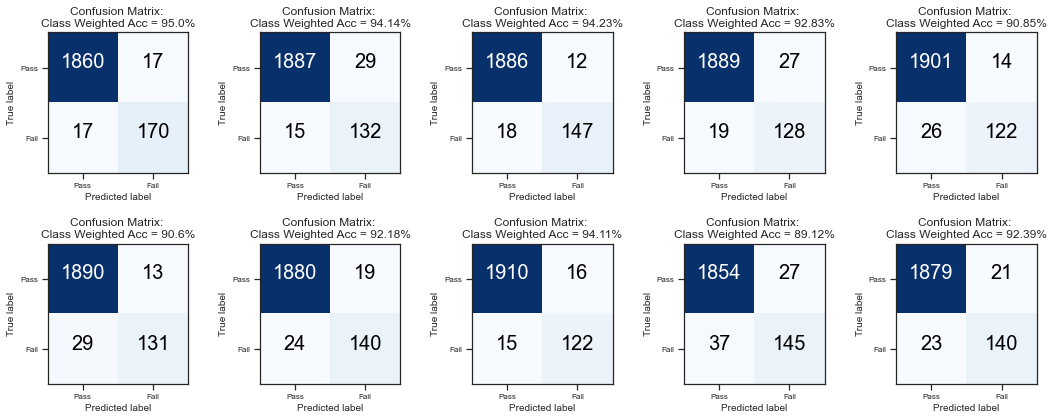

In [182]:
max_params = {}
max_params['params'] = {}
max_params['params']['gamma'] = 0.417022004702574
max_params['params']['learning_rate'] =  0.6042271454095107
max_params['params']['max_depth'] = 1
max_params['params']['n_estimators'] = 337

lgbmMod = LGBMClassifier(**max_params['params'])

n_splits = 10
kf = KFold(n_splits, True, 1)
X = train_bin_clf.drop(['FailureGrade'], axis = 1).values
y = train_bin_clf.drop(train_bin_clf.columns.difference(['FailureGrade']), axis = 1).values

split_scores = []
cm_list = []
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    model_ = clone(lgbmMod)
    model_.fit(trainX,trainy)
    preds = model_.predict(testX)
    classWiseAcc, cm = evaluate(testy, preds)
    split_scores.append(classWiseAcc)
    cm_list.append(cm)  
            
print('Avg Class-wise accuracy = {}'.format(round(sum(split_scores)/len(split_scores), 2)))
n_cols = 5                                      
rows = int(np.ceil(len(cm_list) / n_cols))
f = plt.figure(figsize=(15,3*rows))
classes = ['Pass', 'Fail']
for i, cm in enumerate(cm_list):
    axi = f.add_subplot(rows, n_cols, i+1)
    plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix: \nClass Weighted Acc = '+ str(round(split_scores[i]*100, 2)) + '%', cmap=plt.cm.Blues)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

##### Compare with Random Forest classifier (default parameters)

Avg Class-wise accuracy = 0.91


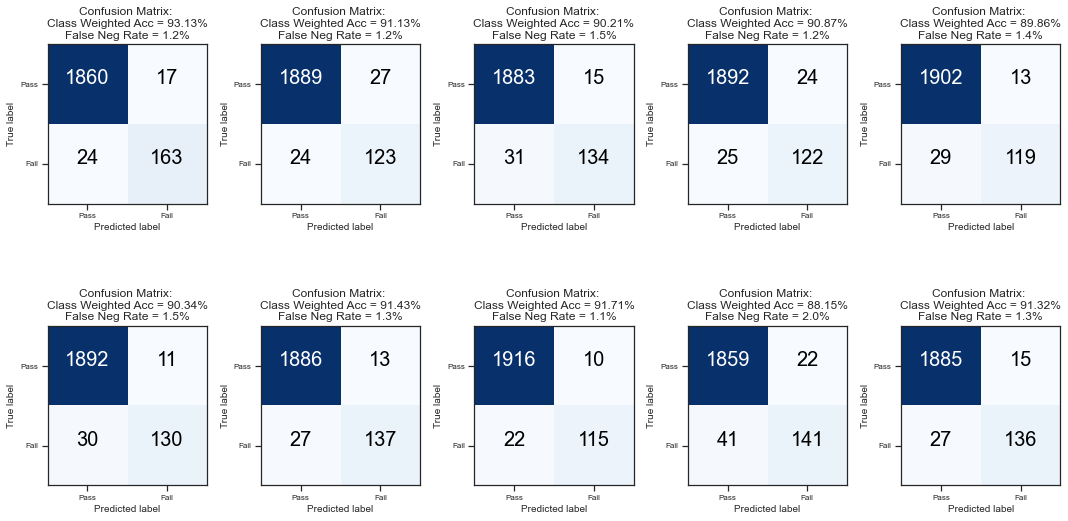

In [171]:
rfMod = RandomForestClassifier()

n_splits = 10
kf = KFold(n_splits, True, 1)
X = train_bin_clf.drop(['FailureGrade'], axis = 1).values
y = train_bin_clf.drop(train_bin_clf.columns.difference(['FailureGrade']), axis = 1).values

split_scores = []
cm_list = []
FN_rates = []
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    model_ = clone(rfMod)
    model_.fit(trainX,trainy)
    preds = model_.predict(testX)
    classWiseAcc, cm = evaluate(testy, preds)
    split_scores.append(classWiseAcc)
    FN = cm.sum(axis=1) - np.diag(cm)
    cm_list.append(cm)
    fn_rate = round(FN[1] / cm.sum(), 3)
    FN_rates.append(fn_rate)
    
            
print('Avg Class-wise accuracy = {}'.format(round(sum(split_scores)/len(split_scores), 2)))
n_cols = 5                                      
rows = int(np.ceil(len(cm_list) / n_cols))
f = plt.figure(figsize=(15,4*rows))
classes = ['Pass', 'Fail']
for i, cm in enumerate(cm_list):
    axi = f.add_subplot(rows, n_cols, i+1)
    plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix: \nClass Weighted Acc = '+ str(round(split_scores[i]*100, 2)) + '%' + '\nFalse Neg Rate = ' + str(round(100 * FN_rates[i], 2)) + '%', cmap=plt.cm.Blues)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)

##### Reciever-Operating Characteristic: ROC Curve

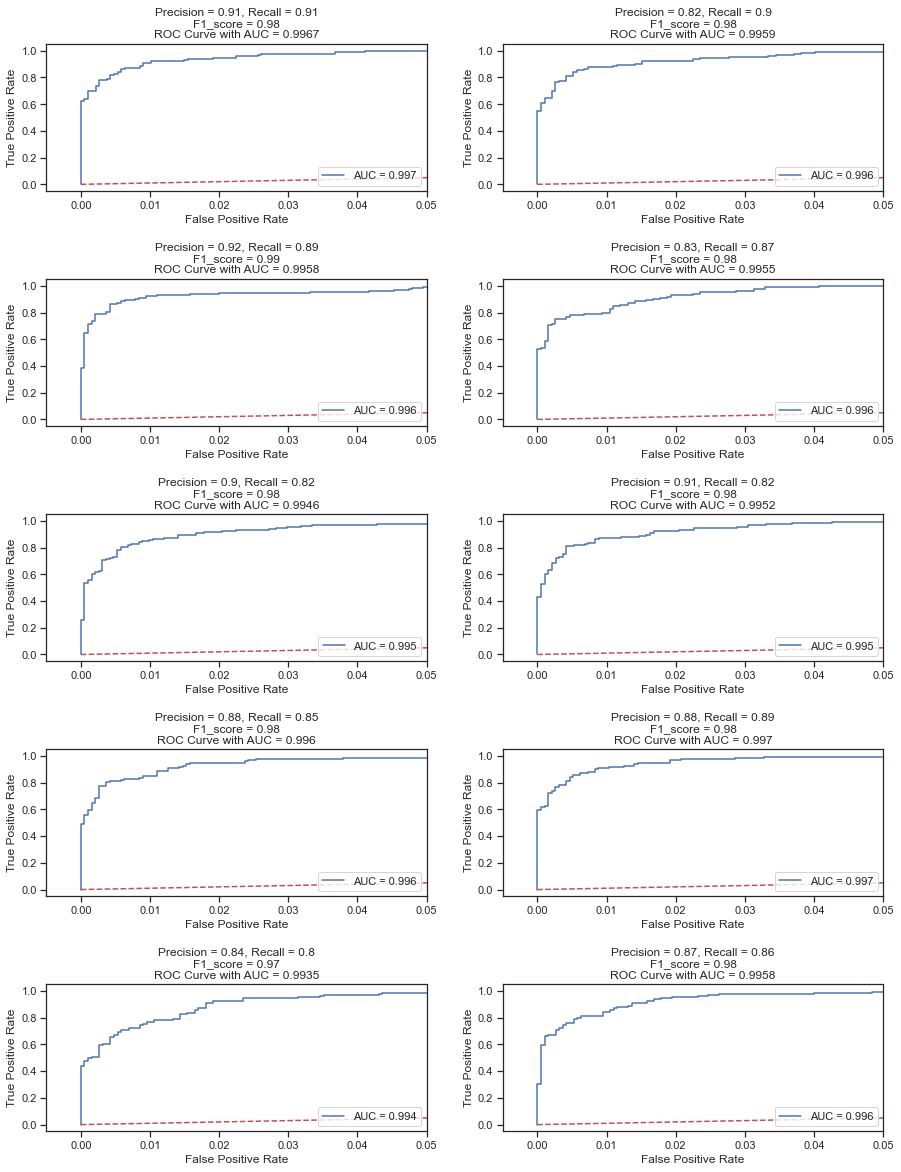

In [196]:
max_params = {}
max_params['params'] = {}
max_params['params']['gamma'] = 0.417022004702574
max_params['params']['learning_rate'] =  0.6042271454095107
max_params['params']['max_depth'] = 1
max_params['params']['n_estimators'] = 337

lgbmMod = LGBMClassifier(**max_params['params'])

split_scores = []
cm_list = []
titleList = []

n_cols = 2      
n_splits = 10

rows = int(np.ceil(n_splits / n_cols))
f = plt.figure(figsize=(15,4*rows))


kf = KFold(n_splits, True, 1)
X = train_bin_clf.drop(['FailureGrade'], axis = 1).values
y = train_bin_clf.drop(train_bin_clf.columns.difference(['FailureGrade']), axis = 1).values

i = 0
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    model_ = clone(lgbmMod)
    model_.fit(trainX,trainy)
    preds = model_.predict(testX)
    y_pred_proba = model_.predict_proba(testX)[:, 1] # probability estimates of the positive class
    
    classWiseAcc, cm = evaluate(testy, preds)
    prec_score = round(precision_score(testy, preds), 2)
    rec_score = round(recall_score(testy, preds), 2)
    f1_score_ = round(f1_score(testy, preds, average='weighted'), 2)
    fpr, tpr, threshold = roc_curve(testy, y_pred_proba)
    roc_auc = round(auc(fpr, tpr), 4)
    
    axi = f.add_subplot(rows, n_cols, i+1)
    title = 'Precision = ' + str(prec_score) + ', Recall = ' + str(rec_score) + '\n' + 'F1_score = ' + str(f1_score_) + '\nROC Curve with AUC = ' + str(roc_auc)
    titleList.append(title) 
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.005, 0.05])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    i += 1
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

In [172]:
threshold

array([1.99996022e+00, 9.99960220e-01, 9.96089883e-01, 9.96048976e-01,
       9.63332048e-01, 9.62777262e-01, 9.42468265e-01, 9.41252310e-01,
       9.37639098e-01, 9.36351127e-01, 8.92031229e-01, 8.89865543e-01,
       8.84487296e-01, 8.66896719e-01, 8.60460628e-01, 8.55857828e-01,
       8.52524166e-01, 8.35653676e-01, 8.04238009e-01, 8.03348078e-01,
       7.92368943e-01, 7.90470503e-01, 7.48914858e-01, 6.80617255e-01,
       6.53267384e-01, 6.04926120e-01, 5.25699161e-01, 5.07946727e-01,
       4.80793572e-01, 4.74539688e-01, 4.73279410e-01, 4.58100690e-01,
       4.53536232e-01, 4.52255263e-01, 4.51779208e-01, 4.42155172e-01,
       4.00564348e-01, 3.90086785e-01, 3.81489880e-01, 3.65809853e-01,
       3.31634344e-01, 3.14105890e-01, 2.74224985e-01, 2.69984574e-01,
       2.62376432e-01, 2.41036928e-01, 2.36081202e-01, 2.23829736e-01,
       1.88920011e-01, 1.48254066e-01, 1.39238542e-01, 1.35406092e-01,
       1.33419546e-01, 1.19223554e-01, 1.19004672e-01, 1.10935081e-01,
      